In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os

In [2]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 2

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [3]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [6]:
resnet_weights_path = r'D:\Github_project\data\dogs and cats\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

#### Define Our Transfer Learning Network Model Consisting of 2 Layers

In [7]:
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))
#include_top: whether to include the fully-connected layer at the top of the network.

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

W1005 21:02:22.239328  2692 deprecation.py:506] From C:\Users\Mr. Wu\Anaconda3\envs\AI\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


#### Compile Our Transfer Learning Model

In [9]:
from tensorflow.python.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

#### Prepare Keras Data Generators

In [12]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        r'D:\Github_project\data\dogs and cats\trainvalidfull4keras\train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        r'D:\Github_project\data\dogs and cats\trainvalidfull4keras\valid',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [13]:
# Max number of steps that these generator will have opportunity to process their source content
# len(train_generator) should be 'no. of available train images / BATCH_SIZE_TRAINING'
# len(valid_generator) should be 'no. of available train images / BATCH_SIZE_VALIDATION'
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 200, 100, 50)

#### Train Our Model With Cats & Dogs Train (splitted) Data Set

In [14]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [15]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights("best.hdf5")

Epoch 1/10
10/10 [==============================] - 402s 40s/step - loss: 0.3265 - acc: 0.8350 - val_loss: 0.0647 - val_acc: 0.9780
Epoch 2/10
10/10 [==============================] - 400s 40s/step - loss: 0.0839 - acc: 0.9730 - val_loss: 0.0498 - val_acc: 0.9810
Epoch 3/10
10/10 [==============================] - 402s 40s/step - loss: 0.0851 - acc: 0.9690 - val_loss: 0.0449 - val_acc: 0.9810
Epoch 4/10
10/10 [==============================] - 398s 40s/step - loss: 0.0760 - acc: 0.9760 - val_loss: 0.0410 - val_acc: 0.9850
Epoch 5/10
10/10 [==============================] - 399s 40s/step - loss: 0.0740 - acc: 0.9750 - val_loss: 0.0428 - val_acc: 0.9850
Epoch 6/10
10/10 [==============================] - 403s 40s/step - loss: 0.0824 - acc: 0.9660 - val_loss: 0.0477 - val_acc: 0.9820
Epoch 7/10
10/10 [==============================] - 395s 40s/step - loss: 0.0570 - acc: 0.9800 - val_loss: 0.0407 - val_acc: 0.9840
Epoch 8/10
10/10 [==============================] - 400s 40s/step - loss: 0.

#### Training Metrics

In [16]:
print(fit_history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


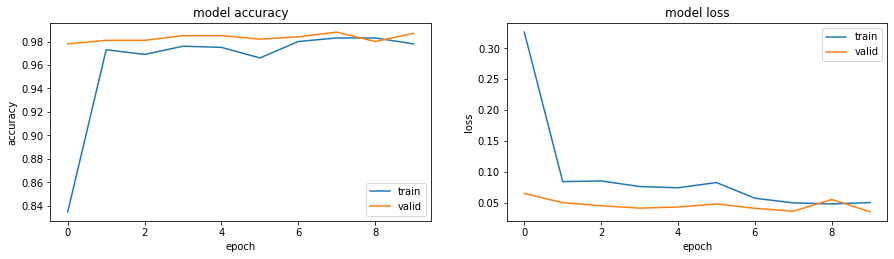

In [17]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [19]:
# NOTE that flow_from_directory treats each sub-folder as a class which works fine for training data
# Actually class_mode=None is a kind of workaround for test data which too must be kept in a subfolder

# batch_size can be 1 or any factor of test dataset size to ensure that test dataset is samples just once, i.e., no data is left out
test_generator = data_generator.flow_from_directory(
    directory = r'D:\Github_project\data\dogs and cats\test4keras',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 12500 images belonging to 1 classes.


#### Observe Prediction Time With Different Batch Size

In [20]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

12500/12500 [==============================] - 1958s 157ms/step


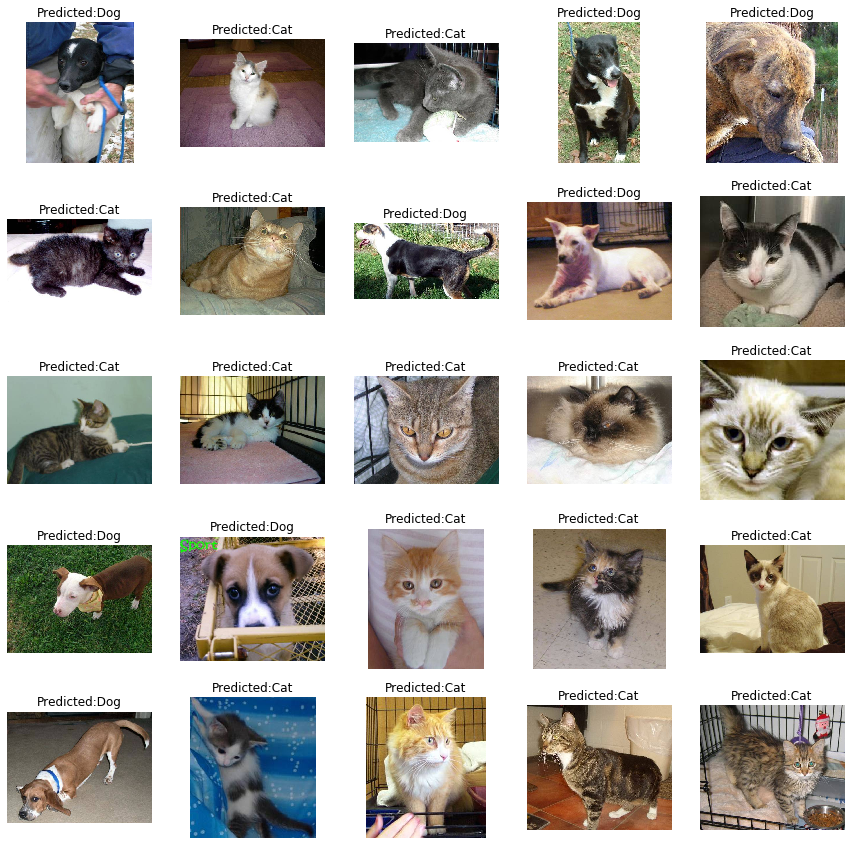

In [38]:
TEST_DIR = 'D:\\Github_project\\data\\dogs and cats\\test4keras\\'
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "Dog" if predicted_class_indices[i] else "Cat"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()

In [39]:
results_df = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames), 
        'label': pd.Series(predicted_class_indices)
    })
results_df['id'] = results_df.id.str.extract('(\d+)')
results_df['id'] = pd.to_numeric(results_df['id'], errors = 'coerce')
results_df.sort_values(by='id', inplace = True)

results_df.to_csv('submission.csv', index=False)
results_df.head()

,id,label
0,1,1
3612,2,1
4723,3,1
5834,4,1
6945,5,0
